In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = False


criteria_dict = {"cs_name_val" : 2,
                 "param_name_str" : "a",
                 "retrain_GP": 10,
                 "num_x_data": 5,
                 "num_val_pts": 0,
                 "lenscl":{"$ne":None}}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [3]:
### Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
1,0,1,1585612.912573,1.0,0.0,"[-0.6274048388613718, -0.20070918286031647, -3...",-3968505466.841713,17153799629.170717,"[0.11332667978016633, -2.0, 0.0, -0.9041302569...",17153799629.170717,"[0.11332667978016633, -2.0, 0.0, -0.9041302569...",0.239508,1,A1,3,0.718525,6.860228
47,0,2,14.276482,1.0,0.0,"[-1.2375146996496642, 0.5683261833443036, -6.1...",6.289765,14.937582,"[-2.0, -2.0, -10.0, -2.0]",14.937582,"[-2.0, -2.0, -10.0, -2.0]",0.180552,1,B1,3,0.541655,4.641121
128,0,38,37389.313494,1.0,902154.177118,"[-0.11902813755175325, -2.0, -8.47040379829104...",32587.124203,35289.126158,"[-0.11932174590577127, -1.8110568460181393, -9...",35289.126158,"[-0.11932174590577127, -1.8110568460181393, -9...",47.147207,1,A2,40,1885.888262,3.363896
904,7,8,14.276482,1.0,342.635558,"[-1.6295234255662696, 0.2153001629366269, -9.2...",10.85443,10.465997,"[-0.7937296994657278, -1.1282982417150957, -4....",10.465997,"[-0.7937296994657278, -1.1282982417150957, -4....",13.037954,1,B2,33,430.252469,1.961224
1160,0,0,1585612.912573,1.0,0.0,"[-0.5376238501428094, -1.5420921394617464, -3....",52158.048072,1780488.41631,"[-0.07026213864114385, 0.9627956890907744, -9....",1780488.41631,"[-0.07026213864114385, 0.9627956890907744, -9....",12.94144,1,C2,2,25.882879,3.443539


In [4]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

5b84a0d8835272a1ebbd187ea785a4d9
2cf6ead0648fda079814855104670531
988cc182076b9894b76e717de6f75360
c14304b5c6475a1d7253c8f2912ee34a
0a0384a12c9df065be519cd8c129c207


Method:  C2
Run Number:  1
BO Iter Number:  1
Trained Hyperparameters:  [array([1.36113749e-01, 2.21573761e+02, 8.30968019e+02, 1.67917241e+00,
       3.00000000e-01, 2.00000000e-01]), 0.0001, 1]


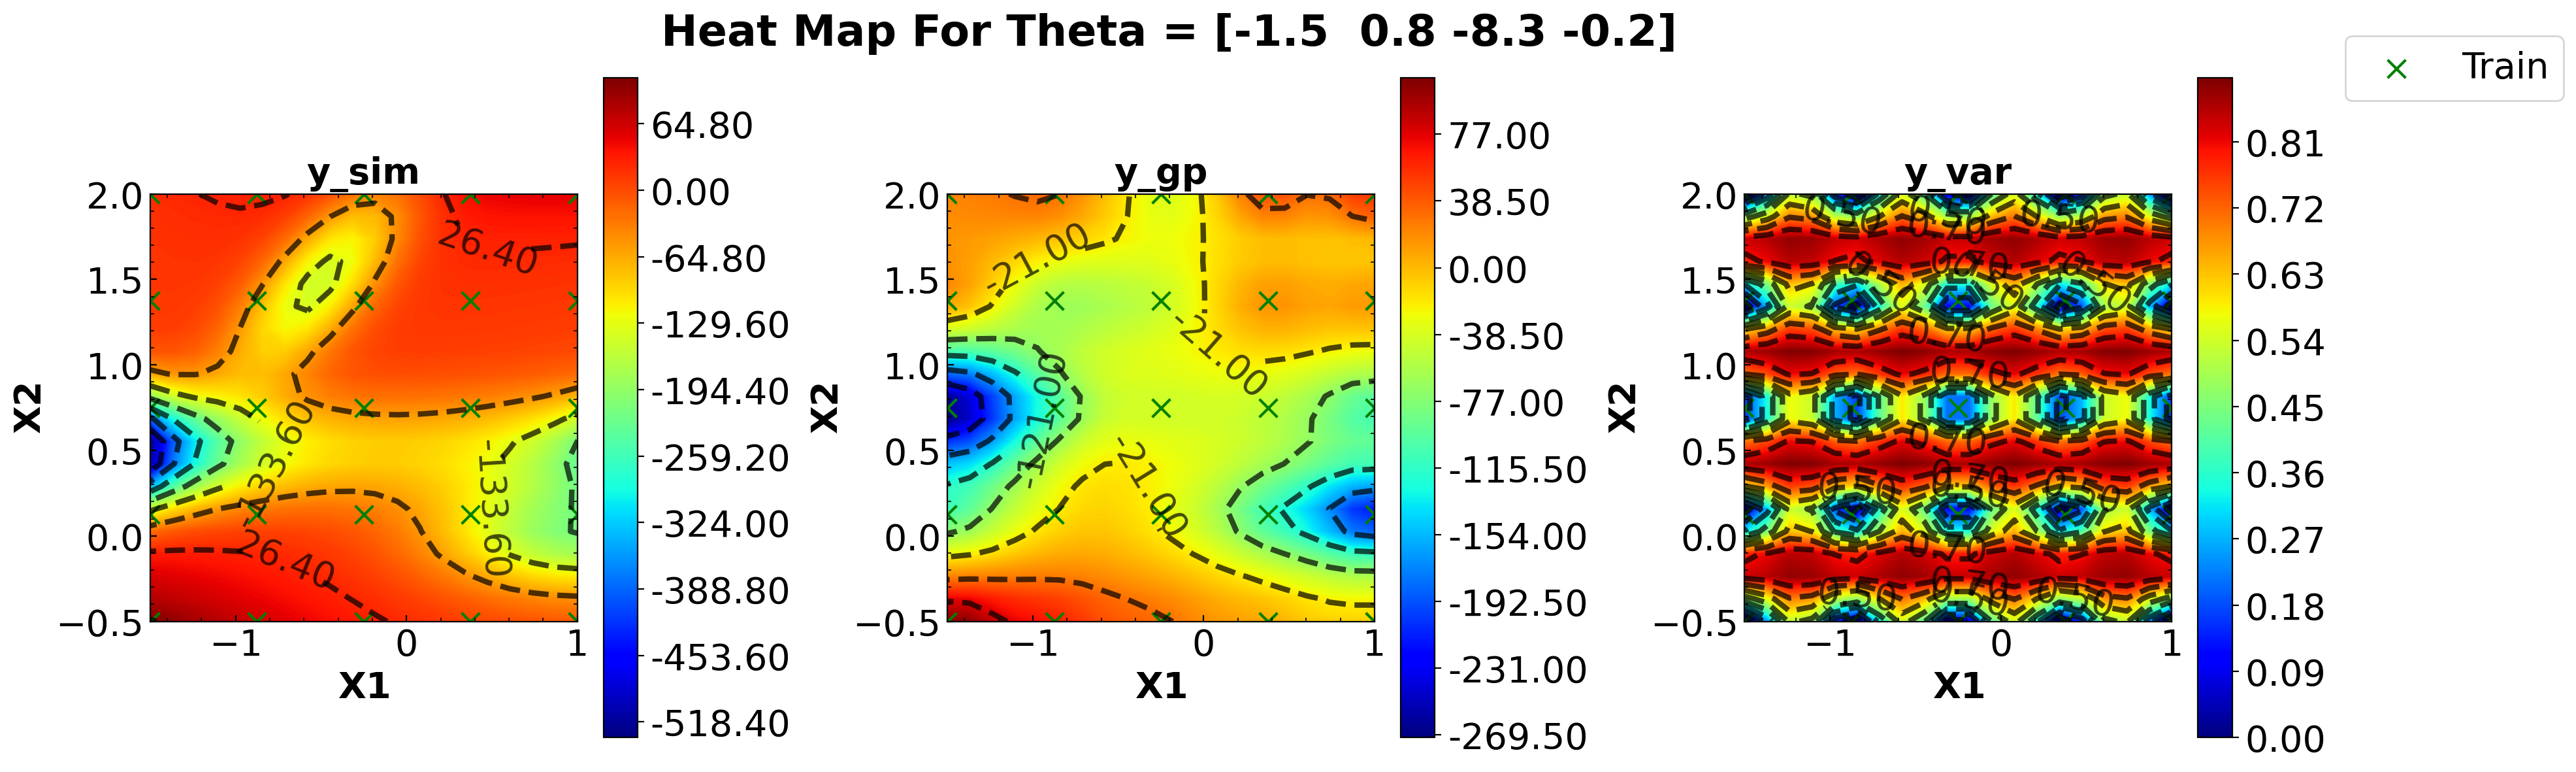

Max EI Theta [-1.52838065  0.76858661 -8.32826196 -0.15766997]


In [5]:
#Plot Muller potential
project = signac.get_project()
meth_name_str_list = [5]
for meth_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_val
    jobs = project.find_jobs(criteria_dict) 
    for job in jobs:
        file_path = job.fn("BO_Results.gz")

    loaded_results = open_file_helper(file_path)
    meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name


    run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
    bo_iter = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'BO Iter'].iloc[0] + 1
    trained_hps = loaded_results[run_num-1].list_gp_emulator_class[bo_iter-1].trained_hyperparams
    print("Method: ", meth_name)
    print("Run Number: ", run_num)
    print("BO Iter Number: ", bo_iter)
    print("Trained Hyperparameters: ", trained_hps)
    x_val_num = 20
    theta_choice = None
    theta_true = loaded_results[run_num-1].simulator_class.theta_true
    theta_choice = theta_true  
#     theta_choice = np.array([-0.12334013, -1.97193209, -9.58736122,  0.70718457]) #(2A Set HPs)
#     theta_choice = np.array([-1.25179735, -1.30799798, -6.38989644,  0.69741102]) #(2A Trained HPs)   
    theta_choice = np.array([-1.52838065,  0.76858661, -8.32826196, -0.15766997]) #(2C Set HPs)

    seed = loaded_results[0].configuration["Seed"]

    title_fontsize = 24
    other_fontsize = 20
    xbins = 4
    ybins = 5
    zbins = 900
    save_path = None
    cmap = "autumn"
    save_path = None

    data_vals = compare_muller_heat_map(file_path, run_num, bo_iter, x_val_num, theta_choice, seed)
    test_mesh, y_sim, gp_mean, gp_var, theta_value, train_X, idcs_to_plot = data_vals
    title = "Heat Map For Theta = " + str(np.round(theta_value,1))

    z = [y_sim]
    z_titles = ["y_sim"]
    
    z = [y_sim,  gp_mean, gp_var]
    z_titles = ["y_sim" , "y_gp", "y_var"]
    
    cmap = "jet"
    levels = [100,100,100]
    plot_axis_names = ["X1", "X2"]
    try:
        plot_heat_maps(test_mesh, None, None, None, train_X, plot_axis_names, levels, idcs_to_plot, z, 
                   z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)
    except:
        pass
print("Max EI Theta", theta_choice)